# Feature Selection

### Feature Selection
<img src="../imgs/03.3.02_1.png" align="right"  width=600><br>

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li> Purpose </li>

<li> Types of feature filtering
<ul>
<li>Linear Correlation</li>
<li>Phik Correlation</li>
<li>Feature importance</li>
<li>Permutation importance</li>
<li>SHAP values</li>
<li>CatBoost feature selection </li>    
<li>Boruta</li>
<li>BoostARoota</li>
    
</ul>
</li>
    
<li>Review features
<li>Conclusion

</li></ul></font></p>

### Purpose

<div class="alert alert-info">

As we can see in the lessons about **Feature engineering** and automatic feature generation, we can quickly generate a large number of features, especially in automatic mode. Why then throw out some of them? <br> 
There are several main reasons:
* The first one, which lies on the surface, is that if there are a lot of features, then the data may no longer fit in memory; the training time of the model may significantly increase, especially if we want to test several different algorithms or an ensemble. Especially when platforms are limited to the duration of a single session (12 hours in Kaggle) and memory consumption limits.
* But the main reason is that as the number of features increases, the accuracy of model prediction often decreases. Especially if there are a lot of junk features in the data (almost not correlating with the target). Some algorithms, with a strong increase in the number of features, generally cease to work adequately. In other words, what we get as a result is **overfitting**
* Even if the accuracy does not decrease, there is a risk that your model relies on noisy features, which will reduce the stability of the forecast for a private sample.

## 1. Feature Selection Methods
There are 3 main Feature Selection methods:
* Filter methods
* Wrapper methods
* Embedded methods

<div class="alert alert-info">    
    
## **1.1 - Filter methods**

These methods are based on statistical methods and, as a rule, consider each feature independently. They allow you to evaluate and rank features according to their significance, which is taken as the degree of correlation of this feature with the target variable. The main advantage of this group of methods is the low cost of calculations, which linearly depends on the total number of features.  They are significantly faster than both wrapper and embedded methods. In addition, they work well even when the number of features exceeds the number of examples in the training sample (which is not always possible for methods of other categories). <br>
The main disadvantage of these methods is that they consider each feature in isolation from the others, so they are not as accurate, but they can quickly sort out the features. However, progress does not stand still and filter methods are emerging that try to solve this problem in different ways - based on mutual information of features, or taking into account the redundancy of features 
(the mRmR method is minimal redundancy with maximum relevance). <br>
Some of these methods are implemented in the `sklearn.feature_selection` section of the scikit-learn library, for example, `SelectKBest`, `chi2`, etc. Similarly, **feature importance** in gradient boosting libraries can be said to be based on this technique, but to the same extent they can be attributed to embedded methods is a debatable issue.

<div class="alert alert-info">    

## **1.2 - Embedded methods**

Where are they embedded? Right into the learning process of the model. These models make it possible not to separate the processes of training and feature selection, i.e., during model training, we filter out and get a model at the output that knows which features to pay more attention to and which are garbage. These methods require less calculations than wrapper methods, but more than filtering methods. As you probably already guessed, the main methods from this group are our "old friends" - regularization (for example, LASSO and Ridge regressions), DecisionTree and randomForest algorithms, there are also regularizations in boosters and neural networks.<br>
Regularization also has disadvantages: at least once you will have to train the model on all the signs and look at the coefficients, which is not always convenient and feasible. Similarly, a model trained on all signs will work slower with inference. But in general, this method is better able to capture the interdependencies of variables than filtering methods.

<div class="alert alert-info">    

## **1.3 - Wrapper methods**
What do they wrap? And they wrap the training of the model in sequential removal (backward feature selection) or addition (forward fs) of features. Backward feature selection is better at tracking the relationships between features, but it is much more computationally expensive.<br>
The main disadvantage of all wrapper methods is the long calculation time. In addition, in the case of a large number of features and a small size of the training dataset, these methods are in danger of overfitting.<br>
Some examples of such methods: RFE (recursive feature elimination) from **scikit-learn** package, **Boruta** of **BorutaPy** (for **RandomForest** algorithm), etc.<br>

<div class="alert alert-info">    

Sometimes it is difficult to determine unequivocally which group a particular method belongs to, or whether it is a hybrid that combines several methods. For example, when using the **CatBoost** gradient boosting library, you can touch all 3 types of methods or a combination of them: if you just take feature importance with default parameters and disabled regularization, we get the filter method; if we add parameters responsible for regularization to the model, we get a kind of hybrid - like the filter method, but at the same time with regularization (embedded method); if we use the `feature_selection()` function built into CatBoost, the wrapper method with backward fs will work.

# Practice

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", "{:,.2f}".format)
from classes import Paths

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
paths = Paths()
path = paths.quickstart_train

df = pd.read_csv(path)
df.head(10)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.74,"12,141,310.41",0.10,180.86,0.02,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.48,"18,039,092.84",0.00,187.86,12.31,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.77,"15,883,659.43",0.10,102.38,2.51,174,173
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.88,"16,518,828.77",0.10,172.79,-5.03,174,170
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.18,"13,983,174.66",0.10,203.46,-14.26,174,171
5,b12101843B,Skoda Rapid,economy,petrol,2.36,2013,42176,2018,48.99,engine_ignition,4.35,"10,855,890.99",0.10,180.89,-18.22,174,173
6,Q-9368117S,Nissan Qashqai,standart,petrol,5.32,2012,24611,2014,54.72,engine_overheat,4.39,"8,343,280.33",0.10,174.98,12.32,174,167
7,O-2124190y,Tesla Model 3,premium,electro,3.90,2017,116872,2019,50.40,gear_stick,4.71,"9,793,288.03",0.10,95.89,-8.94,174,139
8,h16895544p,Kia Sportage,standart,petrol,3.50,2014,56384,2017,33.59,gear_stick,4.51,"16,444,046.89",0.32,101.80,-1.16,174,170
9,K77009462l,Smart ForFour,economy,petrol,4.56,2013,41309,2018,39.04,gear_stick,4.38,"6,975,742.48",0.10,125.25,3.77,174,173


# What we can delete immediately?

<div class="alert alert-info">
    
* Constants
* Unique values (including in the test, usually these are IDs like `car_id`)

In [3]:
df.loc[:, ["deviation_normal_count"]].value_counts()

deviation_normal_count
174                       2337
Name: count, dtype: int64

# Let's add some random features into dataset

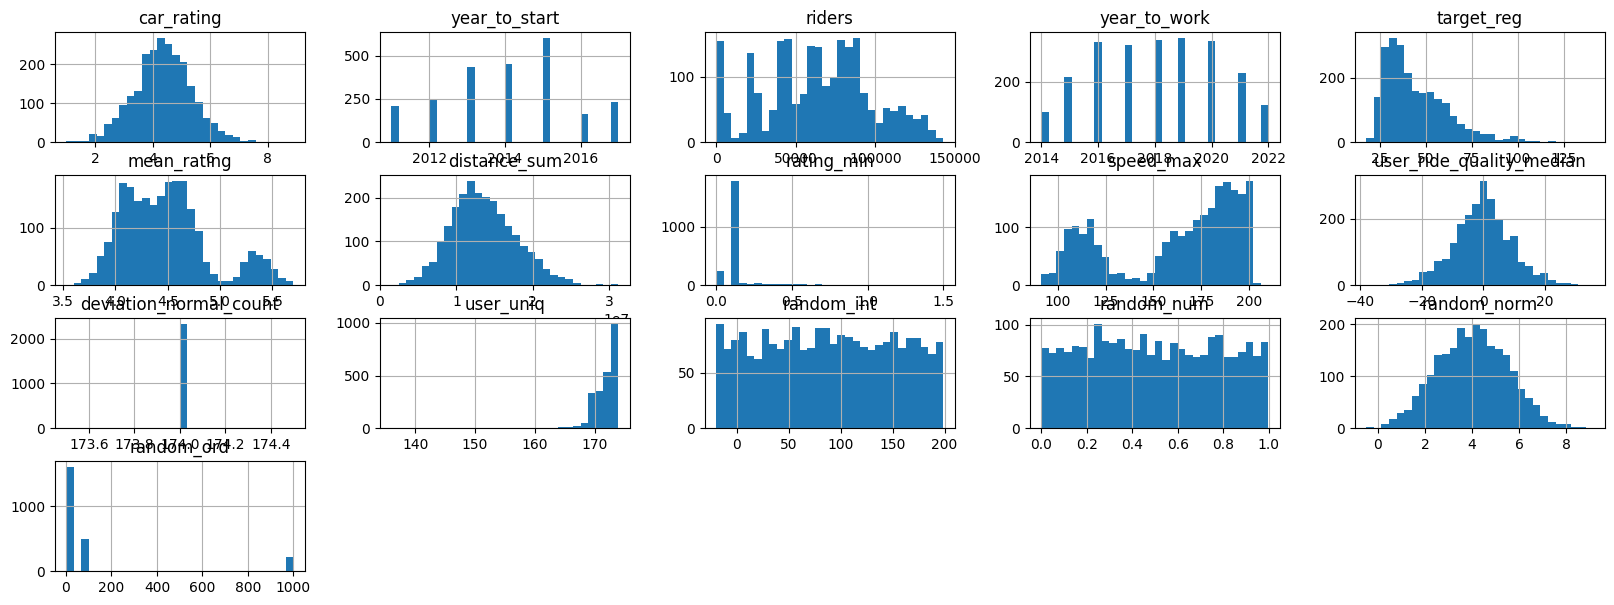

In [4]:
df['random_int'] = np.random.randint(-20, 200, df.shape[0]) # random Whole Numbers Feature
df['random_num'] = np.random.random(size = df.shape[0]) # float type feature with uniform distribution
df['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = df.shape[0]) # normally distributed feature
df['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], size = df.shape[0]) # imbalanced str categorical feature
df['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], size = df.shape[0]) # Numeric Categorical Feature

df.hist(figsize = (20, 7), layout = (-1, 5), bins=30);

# Linear Correlation

<Axes: >

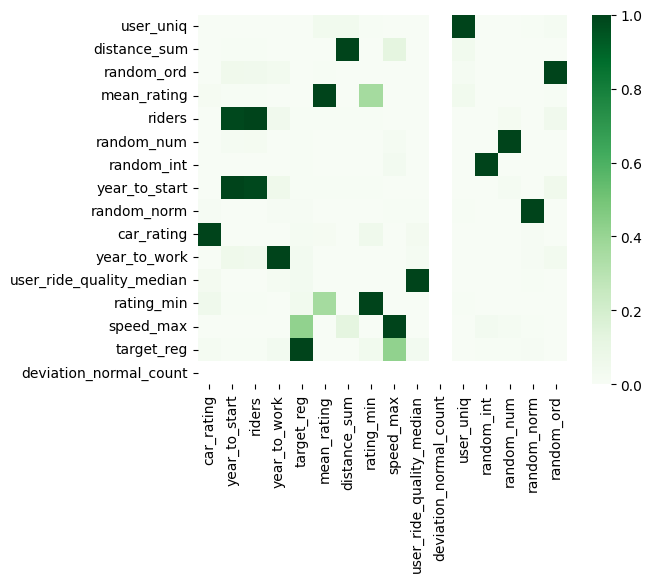

In [5]:
corrs = df.dropna().corr(numeric_only=True).round(3).sort_values(by=['target_reg'])
sns.heatmap(
    corrs
    , cmap='Greens'
    , square=True
    , vmin=-0
)

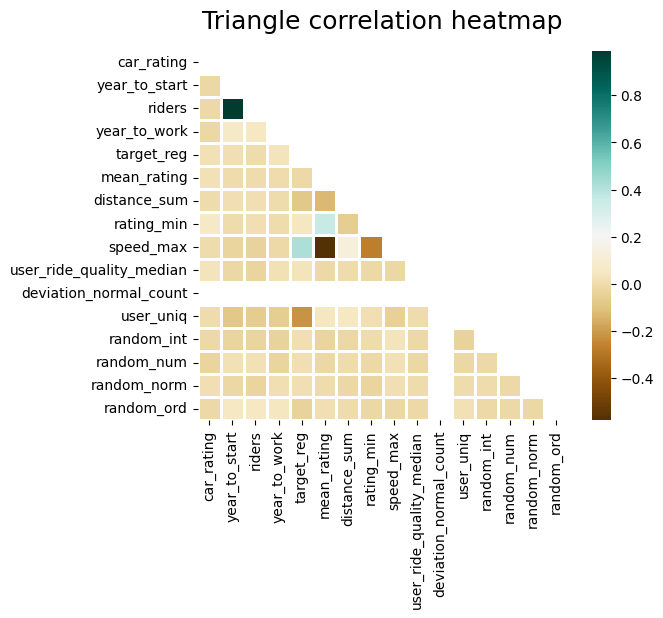

In [6]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
# display(np.ones_like(df.corr(numeric_only=True), dtype=bool)[:3]) # all trues
# display(mask[:3])                                                 # triu - upper trues, tril - lower trues

heatmap = sns.heatmap(
    df.corr(numeric_only=True).round(2),

    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.1},
    linewidth=1,
    
    mask=mask,
)

heatmap.set_title(
    "Triangle correlation heatmap", fontdict={"fontsize": 18}, pad=16
);


<div class="alert alert-success">

**Advantages and disadvantages of correlation filtering?**

* ✅ Fast and clear
* ❌ Does not capture nonlinear dependencies
* ❌ Omits paired dependencies
* ❌ Is not suitable for categories (another stat criterion is needed)

# Phik correlation

* [Documentation](https://pypi.org/project/phik/)
* [Tutorial](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)

In [7]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'random_int', 'random_num', 'random_norm', 'random_ord']


Not enough unique value for variable deviation_normal_count for analysis 1. Dropping this column


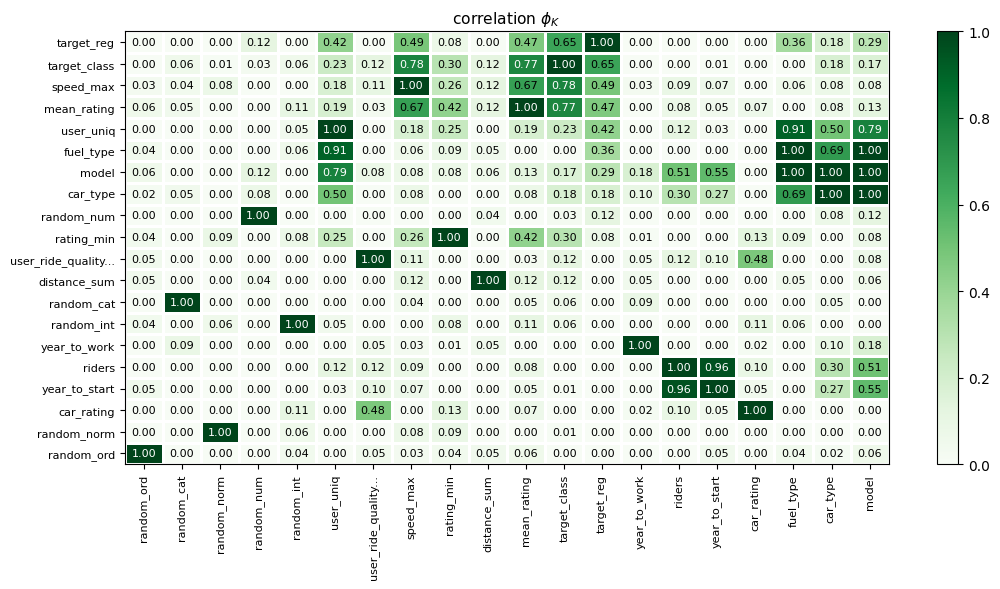

In [8]:
phik_overview = df.drop(columns=['car_id']).phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'random_int', 'random_num', 'random_norm', 'random_ord']


Not enough unique value for variable deviation_normal_count for analysis 1. Dropping this column


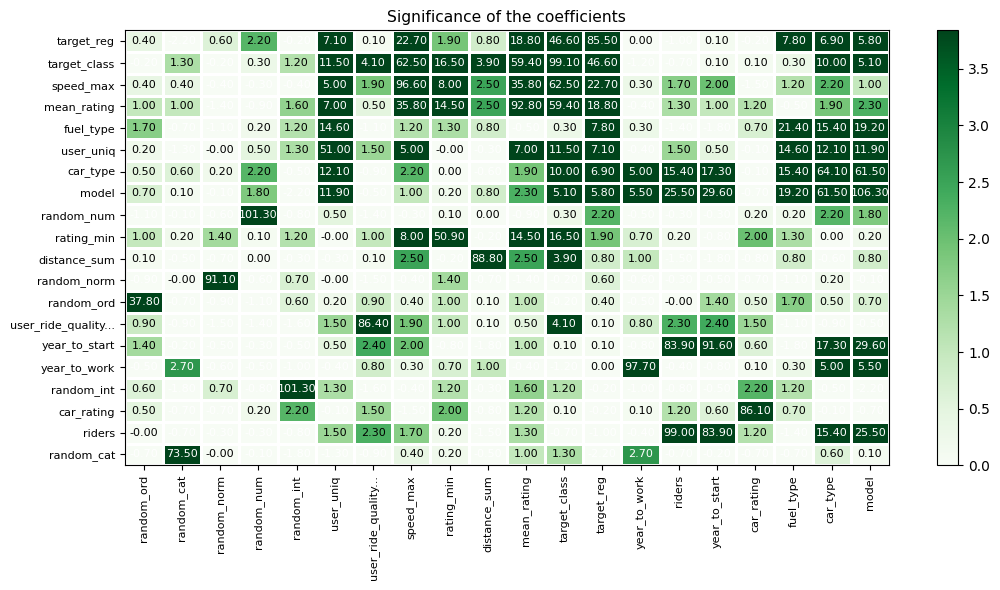

In [9]:
significance_overview = df.drop(columns=['car_id']).significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=3.84, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

<div class="alert alert-success">

**Interpretation of logarithmic probability**

<div class="alert alert-info">

If the logarithmic probability of your result is `greater than 6.63`, the probability that the result will happen by chance is less than 1%. Thus, we can be `99% sure` that the result really means something. In terms of p-value, this is usually expressed as 
- `p < 0.01`.  

If the logarithmic probability `is 3.84 or more`, the probability that this will happen by chance is less than 5%. So we are `95% sure` of the result. In terms of p-value this is expressed as 
- `p < 0.05`.

<div class="alert alert-success">

**Advantages and disadvantages of the `phik` method?**

* ✅ Works with categorical values
* ✅ Finds nonlinear dependencies
* ❌ Does not find paired dependencies
* ❌ Counts for a long time if number of features is too big

# Feature Importance

<div class="alert alert-info">

We will use CatBoost gradient boosting library in example

In [10]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [11]:
drop_cols = ['car_id', 'target_class', 'target_reg']
cat_cols = ['car_type', 'fuel_type', 'model', 'random_cat']

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target_class'].fillna(0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.8570356	test: 1.8674485	best: 1.8674485 (0)	total: 73.8ms	remaining: 1m 13s
100:	learn: 0.3917989	test: 0.5568973	best: 0.5568973 (100)	total: 1.79s	remaining: 15.9s
200:	learn: 0.2720997	test: 0.5552829	best: 0.5543496 (198)	total: 3.47s	remaining: 13.8s
300:	learn: 0.1999995	test: 0.5519321	best: 0.5505572 (272)	total: 5.16s	remaining: 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5505572095
bestIteration = 272

Shrink model to first 273 iterations.


In [14]:
# let's see the importance of catboost features
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,33.75
1,mean_rating,30.54
2,rating_min,12.32
3,model,3.24
4,user_uniq,2.73
5,random_cat,2.66
6,car_type,2.45
7,user_ride_quality_median,1.96
8,distance_sum,1.75
9,riders,1.55


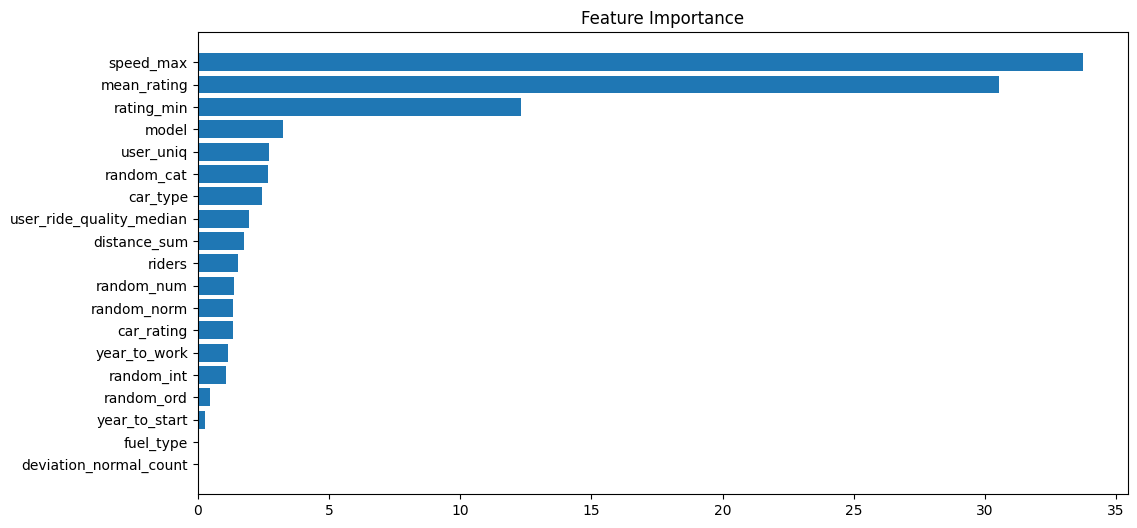

In [15]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

<div class="alert alert-info">

The found top features will not always be the subset on which the model will show the best accuracy. If you take **feature importance** by training the boosting model 1 time, if there are a large number of highly correlated features, they will divide the importance among themselves (because the tree will choose not one of them, but all of them, and the frequency of selection is small) and fall down in the top in importance. Next, if we take the top N, we will cut them off, and garbage will remain in the top.

# `Permutation Importance` - more precise version of `Feature Importance`

<div class="alert alert-info">

The `Permutation Importance` from the `scikit-learn` library randomly shuffles values in one column from the validation dataset, leaving all other columns untouched. A feature is considered "important" if the accuracy of the model decreases and its change causes an increase in errors. On the other hand, a feature is considered "unimportant" if shuffling its values does not affect the accuracy of the model.

<div class="alert alert-warning">

There are many pitfalls in assessing the importance of attributes in this way. For example, the **A** feature is present only in a small proportion of objects, but strongly affects the result, while the B feature has only a small effect on the result, but in all objects. Both of these signs are important, but this importance is of a different kind, and this difference will not be seen in standard methods for assessing the importance of signs.

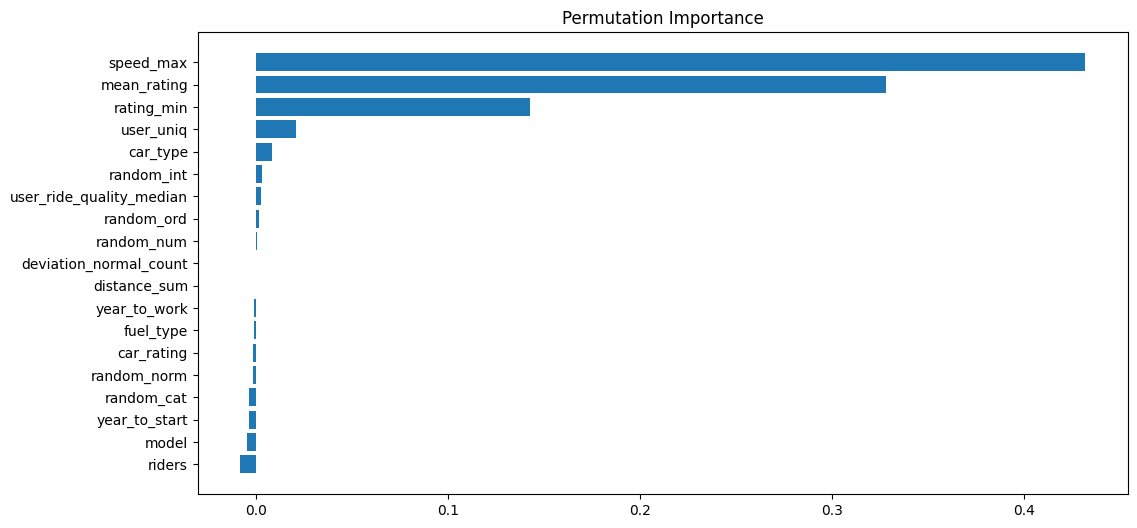

In [16]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

<div class="alert alert-info">

The importance of features may strongly depend on the characteristics of the data distribution, and this distribution may differ in training and inference. This feature adds ambiguity to the notion of the importance of a feature.

**Is it correct to use random variables as a boundary to filter out the others below in terms of importance?**

<div class="alert alert-info">

As we can see, in both the catbust importance and permutation importance, the random feature got into the top 10 of the rating. Therefore, everything below can be considered noise and discarded. Interestingly, the `model` feature turned out to be lower (in terms of imporatnce) than feature created using randomizer, although it was quite high in other ratings.

<div class="alert alert-success">

In general, **the answer is yes, we can do so**, but there are no guarantees that it will improve our model quality. Wex can accidentally throw away useful features. It must be validated!

<div class="alert alert-info">

An overfitted model may give, in general, the wrong importance of features. If the relevance of the features is known in advance, then it can help to recognize overfitting, but if the relevance is not known in advance, then selecting features based on importance can only strengthen overfitting in this case.

# SHAP values

<div class="alert alert-info">

A more modern way to assess the importance of features is **SHAP values**, based on game theory, which allow you to assess the importance of features on a specific test example. SHAP values have some problems too: they depend on the data distribution, that is, they are a characteristic not only of the model, but also of the combined **"model + data distribution"** system. In this case, we can get non-zero SHAP values for those features that are not used by the model in any way.

In [17]:
X_test

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,random_int,random_num,random_norm,random_cat,random_ord
1720,Volkswagen ID.4,premium,electro,4.28,2017,114851,2020,4.14,"11,634,739.07",0.10,190.92,-4.02,174,148,178,0.11,5.89,A,1000
2025,VW Polo VI,economy,petrol,5.00,2015,87354,2018,4.05,"17,976,546.95",0.00,200.00,2.87,174,171,164,0.32,4.61,C,100
1430,Smart ForFour,economy,petrol,4.38,2013,37920,2015,4.39,"15,435,541.25",0.10,183.26,11.77,174,171,140,0.04,4.02,C,1
2320,Kia Sportage,standart,petrol,5.34,2011,3012,2021,4.21,"13,652,642.40",0.10,193.07,5.58,174,172,36,0.14,4.70,C,10
2141,Smart ForTwo,economy,petrol,3.04,2013,44425,2020,4.13,"9,099,348.39",0.10,188.60,4.43,174,174,17,0.80,4.08,A,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,Kia Sportage,standart,petrol,4.28,2015,78106,2016,4.81,"11,076,067.85",0.24,200.00,13.72,174,170,112,0.52,6.06,C,1
1960,Smart ForTwo,economy,petrol,6.54,2013,39439,2019,4.25,"8,114,611.55",0.10,185.47,10.66,174,171,144,0.73,1.76,A,1
1075,Kia Rio,economy,petrol,4.86,2012,30495,2022,4.50,"13,115,669.00",0.10,108.29,-3.44,174,174,134,0.77,5.33,C,1
1185,Kia Rio X-line,economy,petrol,6.66,2012,20822,2016,4.08,"6,850,545.18",0.10,165.96,2.56,174,172,107,0.58,3.95,C,100


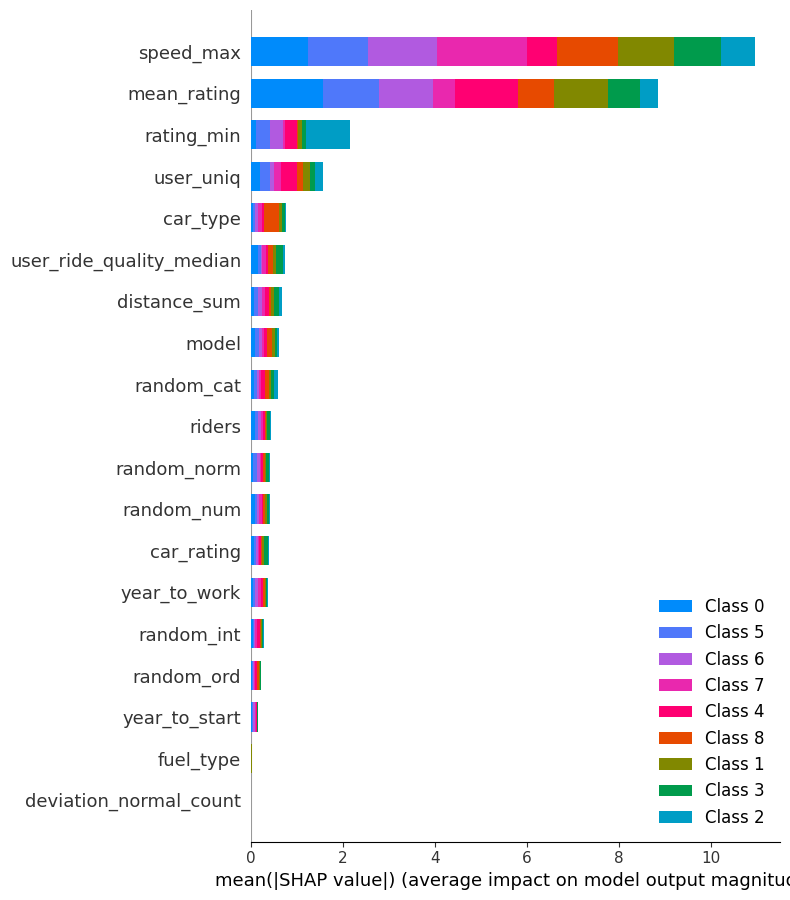

In [18]:
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25, plot_type='bar', feature_names=X_test.columns.values);


# CatBoost feature selection (recursive methods)

<div class="alert alert-info">

<div class="alert alert-success">

**The idea behind recursive algorithms is to remove features and see if the quality decreases. If it has not decreased, it means that the feature is "bad".**

</div>

The CatBoost library has a built-in method for selecting features [select_features](https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features), which supports 3 feature selection algorithms - the `algorithm` parameter:
* `RecursiveByPredictionValuesChange` is the fastest and fairly accurate
* `RecursiveByLossFunctionChange` - optimal in terms of accuracy/speed ratio
* `RecursiveByShapValues` (by default) - the most accurate, but the most resource-intensive <br>

If we don't have enough time (resources) for the most accurate algorithm, we can try other ones.

In [19]:
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-13',
                      num_features_to_select=8,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

In [20]:
# Let's see the list of selected features (not ranked by importance)
print(summary['selected_features_names'])
# And the best loss value
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['car_type', 'car_rating', 'mean_rating', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
Best loss: 0.5325746325118766


In [21]:
# In summary, the full report of the algorithm is saved
summary

{'selected_features': [1, 3, 7, 9, 10, 11, 12, 13],
 'eliminated_features_names': ['year_to_start',
  'year_to_work',
  'model',
  'riders',
  'distance_sum',
  'fuel_type'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6],
  'loss_values': [0.5397920460982361,
   0.5377941143755449,
   0.5360908321907324,
   0.5346599836438453,
   0.5332814870064193,
   0.5326160935057056,
   0.5325746325118766]},
 'eliminated_features': [4, 6, 0, 5, 8, 2],
 'selected_features_names': ['car_type',
  'car_rating',
  'mean_rating',
  'rating_min',
  'speed_max',
  'user_ride_quality_median',
  'deviation_normal_count',
  'user_uniq']}

<div class="alert alert-info">

We see that with each iteration, 1 feature was discarded and the accuracy increased each time.

# Boruta

<div class="alert alert-info">

Boruta is a feature selection method that was first implemented in R language. It only works well with the RandomForest algorithm and takes a long time to calculate. <br>

<div class="alert alert-success">

Approximate working principle: 
* A copy of all the features from the original dataset is created; 
* The values of new features are randomly mixed - these mixed doubles are called "shadow features"
* Next, random forest training is started N times, which makes it possible to smooth out random noise when evaluating the importance
* Then, according to the calculated threshold, some of the features are dropped out
* And a new round starts from the first step above (N rounds)
* As a result, the initial features fall into 3 zones - red, blue and green
* All features from the red zone can be removed, we keep features from the blue zone, and the green ones are the strongest.

In [22]:
X_train[cat_cols] = X_train[cat_cols].astype(str)

X_train_one_hot = pd.get_dummies(X_train[cat_cols])
X_train = pd.concat((X_train.drop(columns=cat_cols), X_train_one_hot), axis=1).fillna(0)
X_train.head()

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,random_int,random_num,random_norm,random_ord,car_type_business,car_type_economy,car_type_premium,car_type_standart,fuel_type_electro,fuel_type_petrol,model_Audi A3,model_Audi A4,model_Audi Q3,model_BMW 320i,model_Fiat 500,model_Hyundai Solaris,model_Kia Rio,model_Kia Rio X,model_Kia Rio X-line,model_Kia Sportage,model_MINI CooperSE,model_Mercedes-Benz E200,model_Mercedes-Benz GLC,model_Mini Cooper,model_Nissan Qashqai,model_Renault Kaptur,model_Renault Sandero,model_Skoda Rapid,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4,random_cat_A,random_cat_B,random_cat_C,random_cat_D
1573,3.44,2011,684,2022,4.56,"12,293,337.60",0.00,200.00,-2.78,174,172,45,0.78,2.43,1,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
65,4.62,2015,87418,2019,3.99,"12,960,569.02",0.10,179.76,-27.86,174,173,13,0.30,3.73,100,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1251,3.52,2017,109933,2021,4.30,"10,207,253.88",0.10,189.83,-7.95,174,170,192,0.14,5.10,100,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
353,5.30,2013,40347,2017,4.20,"11,950,702.32",0.10,177.86,-4.11,174,170,89,0.35,3.39,100,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
700,4.16,2016,110318,2019,5.42,"14,159,517.99",0.10,103.77,-1.59,174,172,199,0.56,2.88,1,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [23]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [24]:
# initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1, 
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest, 
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
    verbose=1
)
# fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_train))
# print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	7
Rejected: 	44
features in the green area: []
features in the blue area: ['mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq', 'car_type_economy']
features in the red area: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'deviation_normal_count', 'random_int', 'random_num', 'random_norm', 'random_ord', 'car_type_business', 'car_type_premium', 'car_type_standart', 'fuel_type_electro', 'fuel_type_petrol', 'model_Audi A3', 'model_Audi A4', 'model_Audi Q3', 'model_BMW 320i', 'model_Fiat 500', 'model_Hyundai Solaris', 'model_Kia Rio', 'model_Kia Rio X', 'model_Kia Rio X-line', 'model_Kia Sportage', 'model_MINI CooperSE', 'model_Mercedes-Benz E200', 'model_Mercedes-Benz GLC', 'model_Mini Cooper', 'model_Nissan Qashqai', 'model_Renault Kaptur', 'm

<div class="alert alert-info">
    
Boruta shows good results in combination with a random forest algorithm, but it has the disadvantage of slow calculations, especially on large data sizes. Regardless of the calculation time, Boruta does not work well on other algorithms, such as boosting or neural networks, although it works well on random forests. Similar problems arise with LASSO regularization, ElasticNet, or Ridge regression – they work well on linear regressions, but poorly on other modern algorithms.

In [25]:
from boostaroota import BoostARoota
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [26]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
br = BoostARoota(metric='logloss', silent=True)

# fit the model for the subset of variables
# br.fit(X_train, y_train_enc)

In [27]:
X_train

,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,random_int,random_num,random_norm,random_ord,car_type_business,car_type_economy,car_type_premium,car_type_standart,fuel_type_electro,fuel_type_petrol,model_Audi A3,model_Audi A4,model_Audi Q3,model_BMW 320i,model_Fiat 500,model_Hyundai Solaris,model_Kia Rio,model_Kia Rio X,model_Kia Rio X-line,model_Kia Sportage,model_MINI CooperSE,model_Mercedes-Benz E200,model_Mercedes-Benz GLC,model_Mini Cooper,model_Nissan Qashqai,model_Renault Kaptur,model_Renault Sandero,model_Skoda Rapid,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4,random_cat_A,random_cat_B,random_cat_C,random_cat_D
1573,3.44,2011,684,2022,4.56,"12,293,337.60",0.00,200.00,-2.78,174,172,45,0.78,2.43,1,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
65,4.62,2015,87418,2019,3.99,"12,960,569.02",0.10,179.76,-27.86,174,173,13,0.30,3.73,100,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1251,3.52,2017,109933,2021,4.30,"10,207,253.88",0.10,189.83,-7.95,174,170,192,0.14,5.10,100,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
353,5.30,2013,40347,2017,4.20,"11,950,702.32",0.10,177.86,-4.11,174,170,89,0.35,3.39,100,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
700,4.16,2016,110318,2019,5.42,"14,159,517.99",0.10,103.77,-1.59,174,172,199,0.56,2.88,1,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2.80,2017,117447,2018,3.94,"14,277,335.14",0.10,167.27,-12.72,174,173,14,0.87,5.72,1,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1095,4.76,2015,88182,2020,4.10,"19,730,706.29",0.10,192.00,3.41,174,173,106,0.26,4.13,100,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1130,4.88,2015,79140,2016,4.63,"5,147,586.58",0.10,127.47,-8.51,174,170,7,0.26,1.85,10,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1294,2.56,2015,85195,2016,5.54,"9,648,842.76",0.10,120.14,-9.83,174,171,8,0.14,5.07,10,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True


In [ ]:
# in boostaroota lib rewrite
# df['Mean'] = df.mean(axis=1)
# into
# df['Mean'] = df.mean(axis=1, numeric_only=True)
br.fit(X_train, y_train_enc)

In [ ]:
# We can look at the feature importance values as follows:
pd.DataFrame(br.keep_vars_)

,feature
33,car_rating
34,car_type_business
35,car_type_economy
36,car_type_standart
37,distance_sum
38,mean_rating
39,model_Hyundai Solaris
40,model_Kia Rio
41,model_Kia Rio X
42,model_Kia Rio X-line
